In [36]:
# import wandb
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
# from sklearn.preprocessing import binarize


from models import MLP
from losses import an_full_loss, full_weighted_loss
from data.Datasets import PatchesDatasetCooccurrences
from data.PatchesProviders import MultipleRasterPatchProvider, RasterPatchProvider

In [2]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"DEVICE: {dev}\n")

DEVICE: cuda



In [3]:
patch_size = 1
flatten = True
learning_rate = 1e-3
n_layers = 5
width = 1000
n_max_low_occ = 50
batch_size = 256
learning_rate = 1e-3

In [4]:
datadir = 'data/full_data/'
po_path = datadir+'Presence_only_occurrences/Presences_only_train_sampled_100_percent_min_1_occurrences.csv' 
bg_path = datadir+'Presence_only_occurrences/Pseudoabsence_locations_bioclim_soil.csv'
pa_path = datadir+'Presence_Absence_surveys/Presences_Absences_train.csv'

bioclim_dir = datadir+'EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/'
soil_dir = datadir+'EnvironmentalRasters/Soilgrids/'
landcover_dir = datadir+'EnvironmentalRasters/LandCover/LandCover_MODIS_Terra-Aqua_500m.tif'

In [6]:
p_bioclim = MultipleRasterPatchProvider(bioclim_dir, size=patch_size, flatten=flatten) 
p_soil = MultipleRasterPatchProvider(soil_dir, size=patch_size, flatten=flatten) 
p_landcover = RasterPatchProvider(landcover_dir, size=patch_size, flatten=flatten)

In [7]:
train_data = PatchesDatasetCooccurrences(occurrences=po_path, providers=(p_bioclim, p_soil, p_landcover), pseudoabsences=bg_path)
print(f"\nTRAINING DATA: n_items={len(train_data)}, n_species={len(train_data.species)}")

n_features = train_data[0][0].shape[0]
n_species = len(train_data.species)
print(f"nb of features = {n_features}")

low_occ_species = train_data.species_counts[train_data.species_counts <= n_max_low_occ].index
low_occ_species_idx = np.where(np.isin(train_data.species, low_occ_species))[0]
print(f"nb of species with less than {n_max_low_occ} occurrences = {len(low_occ_species_idx)}")

val_data = PatchesDatasetCooccurrences(occurrences=pa_path, providers=(p_bioclim, p_soil, p_landcover), species=train_data.species)
print(f"\nVALIDATION DATA: n_items={len(val_data)}, n_species={len(val_data.species)}")

nb items = 2856818
nb species = 2174
nb pseudoabsences = 2856818

TRAINING DATA: n_items=2856818, n_species=2174
nb of features = 41
nb of species with less than 50 occurrences = 468
nb items = 7438
nb species = 2174

VALIDATION DATA: n_items=7438, n_species=2174


In [9]:
species_counts = list(train_data.species_counts)

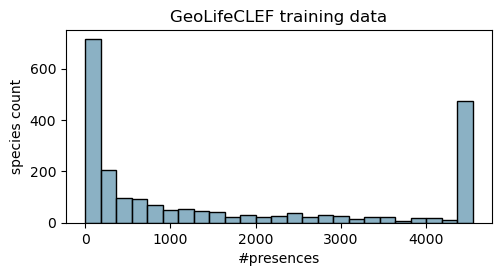

In [12]:
plt.figure(figsize=(5.5,2.5))
sns.histplot(species_counts, bins=25, color='#6497B1')
plt.ylabel("species count")
plt.xlabel("#presences")
plt.title("GeoLifeCLEF training data")
plt.savefig("figures/species_counts_geolifeclef.pdf", bbox_inches='tight')
plt.show()

In [31]:
def get_results(run_name, val_data, checkpoint_to_load='last'):
    val_loader = torch.utils.data.DataLoader(val_data, shuffle=False, batch_size=batch_size, num_workers=4)
    model = MLP(n_features, n_species, n_layers, width).to(dev)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    print('\nLoading model checkpoint...')
    checkpoint = torch.load(f"models/{run_name}/{checkpoint_to_load}.pth")
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    print('\nEvaluating validation data...')
    model.eval()
    labels_list, y_pred_list = [], []
    for inputs, labels in tqdm(val_loader):
        inputs = inputs.to(torch.float32).to(dev)
        labels = labels.to(torch.float32).to(dev)
        labels_list.append(labels.cpu().detach().numpy())
        y_pred = model(inputs)
        y_pred_sigmoid = torch.sigmoid(y_pred)
        y_pred_list.append(y_pred_sigmoid.cpu().detach().numpy())

    labels = np.concatenate(labels_list)
    y_pred = np.concatenate(y_pred_list)
    auc_list = [roc_auc_score(labels[:,i], y_pred[:,i]) for i in range(labels.shape[1])]

    return auc_list

In [33]:
results = {}
runs = {'BCE_loss': '0201_MLP_env_1x1_bce_loss_all_PA_species',
        'full_loss': '0201_MLP_env_1x1_an_full_loss_all_PA_species_with_pseudoabsences',
        'weighted_loss': '0201_MLP_env_1x1_weighted_loss_05_all_PA_species_with_pseudoabsences'
}
for name, run_name in runs.items():
    results[name] = get_results(run_name, val_data)


Loading model checkpoint...

Evaluating validation data...


100%|██████████| 30/30 [00:01<00:00, 28.17it/s]



Loading model checkpoint...

Evaluating validation data...


100%|██████████| 30/30 [00:01<00:00, 28.23it/s]



Loading model checkpoint...

Evaluating validation data...


100%|██████████| 30/30 [00:01<00:00, 27.06it/s]


In [119]:
results_geolifeclef = pd.DataFrame(results)
results_geolifeclef['num_presences'] = train_data.species_counts.values
results_geolifeclef

,BCE_loss,full_loss,weighted_loss,num_presences
0,0.325510,0.942233,0.958821,2261
1,0.321852,0.641626,0.687385,4529
2,0.370981,0.938100,0.940468,2162
3,0.534086,0.668044,0.666231,4508
4,0.434349,0.808725,0.829301,4539
...,...,...,...,...
2169,0.167003,0.913114,0.935665,204
2170,0.701761,0.799381,0.062122,20
2171,0.458283,0.467925,0.537498,110
2172,0.749361,0.944332,0.989781,10


In [122]:
results_geolifeclef.to_csv('figures/geolifeclef_auc_results.csv',index=False)

In [107]:
results_geolifeclef['num_presences_cat'] = pd.cut(results_geolifeclef['num_presences'], [1, 50, 500, 3000, 4600]) 
print(results_geolifeclef.groupby('num_presences_cat').count().BCE_loss)
results_geolifeclef = pd.melt(results_geolifeclef, value_vars=["BCE_loss", "full_loss", "weighted_loss"], id_vars=["num_presences", "num_presences_cat"], var_name='loss', value_name='AUC')
results_geolifeclef

num_presences_cat
(1, 50]         422
(50, 500]       536
(500, 3000]     569
(3000, 4600]    601
Name: BCE_loss, dtype: int64


,num_presences,num_presences_cat,loss,AUC
0,2261,"(500, 3000]",BCE_loss,0.325510
1,4529,"(3000, 4600]",BCE_loss,0.321852
2,2162,"(500, 3000]",BCE_loss,0.370981
3,4508,"(3000, 4600]",BCE_loss,0.534086
4,4539,"(3000, 4600]",BCE_loss,0.434349
...,...,...,...,...
6517,204,"(50, 500]",weighted_loss,0.935665
6518,20,"(1, 50]",weighted_loss,0.062122
6519,110,"(50, 500]",weighted_loss,0.537498
6520,10,"(1, 50]",weighted_loss,0.989781


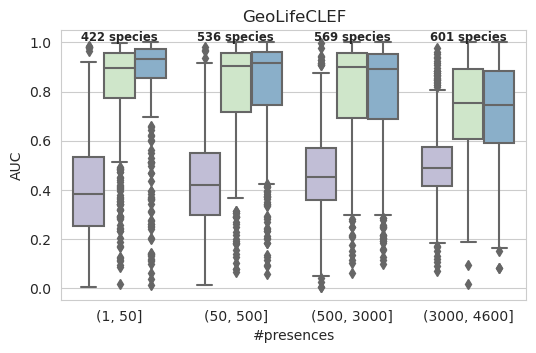

In [117]:
sns.set_style('whitegrid')
figure, axis = plt.subplots(1, 1, figsize=(6,3.5))
sns.boxplot(data=results_geolifeclef, x="num_presences_cat", y="AUC", hue="loss", ax=axis, palette=[sns.color_palette("Set3")[2], sns.color_palette("Set3")[10], sns.color_palette("Set3")[4]])
axis.get_legend().set_visible(False)
axis.set_ylabel("AUC")
axis.set_xlabel("#presences")
medians = [1, 1, 1, 1]
nobs = results_geolifeclef.groupby('num_presences_cat').count().loss/3
nobs = [str(int(x)) for x in nobs.tolist()]
nobs = nobs = [i + " species" for i in nobs]#["#species: " + i for i in nobs]
 
pos = range(len(nobs))
for tick,label in zip(pos,axis.get_xticklabels()):
    axis.text(pos[tick],
            medians[tick] + 0.006,
            nobs[tick],
            horizontalalignment='center',
            size='small', weight='semibold')
plt.title("GeoLifeCLEF")
plt.savefig("figures/results_geolifeclef.pdf", bbox_inches="tight")
plt.show()
sns.set_style('white')